<a href="https://colab.research.google.com/github/gusti-amber/udemy_pytorch/blob/main/lecture/lec3_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 手描き文字認識の実装

# 1. データの読み込み
torchvision.datasetsを使って手書き文字のデータを読み込み、DataLoaderを設定します。

torchvision.datasetsにはMNISTの他にも様々なデータセットが用意されています。

https://pytorch.org/docs/stable/torchvision/datasets.html

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データの取得
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.21MB/s]

訓練データの数: 60000 テストデータの数: 10000


In [3]:
# DataLoaderの設定
img_size = 28 # 手描き文字画像のサイズは28*28
batch_size = 256

train_loader = DataLoader(mnist_train,
                          batch_size = batch_size,
                          shuffle = True)
test_loader = DataLoader(mnist_test,
                          batch_size = batch_size,
                          shuffle = False)

# 2. モデルの構築
nn.Moduleモジュールを継承したクラスとしてモデルを構築する。

.cuda()により、モデルの計算はGPU上で行われるようになる。

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size*img_size, 1024) # 全結合層
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):
    x = x.view(-1, img_size*img_size) # バッチサイズ, 画像サイズ
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net.cuda() # GPU対応
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


# 3. モデルの学習
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行う。

1エポックの中で何度もミニバッチを使って訓練が行われるので、ミニバッチ法による実装になる。

In [5]:
from torch import optim

# 損失関数: 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム: SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失ログ
record_loss_train = []
record_loss_test = []

# モデルの学習
for i in range(10): # 10エポック
  net.train() # 訓練モードに設定

  # ミニバッチ法
  loss_train = 0 # 累積誤差
  for j,(x,t) in enumerate(train_loader): # ミニバッチ(x,t)を取り出す
    x,t = x.cuda(), t.cuda() # GPU対応

    # 順伝播
    y = net(x)
    loss = loss_fnc(y,t)
    loss_train += loss.item()

    # 逆伝播
    optimizer.zero_grad() # 勾配の初期化
    loss.backward()
    optimizer.step()

  loss_train /= j+1 # ミニバッチのサイズで平均を取る
  record_loss_train.append(loss_train)

  net.eval() # 評価モードに設定

  loss_test = 0 # 累積誤差
  for j,(x,t) in enumerate(test_loader): # ミニバッチ(x,t)を取り出す
    x,t = x.cuda(), t.cuda() # GPU対応

    # 順伝播
    y = net(x)
    loss = loss_fnc(y,t)
    loss_test += loss.item()

  loss_test /= j+1
  record_loss_test.append(loss_test)

  if i%1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_test:", loss_test)




Epoch: 0 Loss_Train: 2.219256138294301 Loss_test: 2.095355933904648
Epoch: 1 Loss_Train: 1.8408889618325741 Loss_test: 1.4759343713521957
Epoch: 2 Loss_Train: 1.1440459345249419 Loss_test: 0.852688667178154
Epoch: 3 Loss_Train: 0.737278787633206 Loss_test: 0.6115267015993595
Epoch: 4 Loss_Train: 0.57276071652453 Loss_test: 0.5018005631864071
Epoch: 5 Loss_Train: 0.4894566617113479 Loss_test: 0.4394384536892176
Epoch: 6 Loss_Train: 0.43953533083834545 Loss_test: 0.4007157783955336
Epoch: 7 Loss_Train: 0.40647943730049946 Loss_test: 0.3749059073626995
Epoch: 8 Loss_Train: 0.383523192304246 Loss_test: 0.35326665826141834
Epoch: 9 Loss_Train: 0.3647608824866883 Loss_test: 0.33931159880012274


# 4. 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示する。

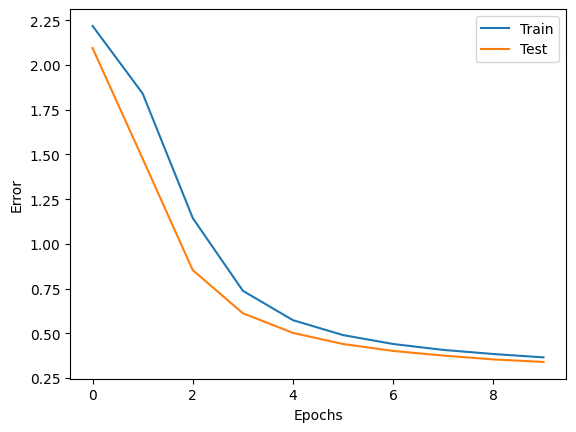

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# 5. モデルの評価
モデルの性能評価のため、テストデータを使い正解率を測定する。

In [8]:
correct = 0
total = 0
for i,(x,t) in enumerate(test_loader):
  x,t = x.cuda(), t.cuda() # GPU対応

  # 変換前: torch.Size([256, 1, 28, 28])
  x = x.view(-1, img_size*img_size)
  # 変換後: torch.Size([256, 784])

  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)
print("正解率:", str(correct/total * 100) + "%")



正解率: 90.27%
